# IMPORTS

In [132]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import cross_val_score
from scipy.interpolate import make_interp_spline
import seaborn as sns

# Extra imports for optimized KNN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Preparação dos Dados

## Carregamento do Dataset

In [133]:
df = pd.read_csv("glioma.csv")

In [134]:
df.head()

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,NF1,PIK3R1,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,0,0,51.30,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,38.72,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,35.17,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,32.78,0,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
4,0,0,31.51,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Grade             839 non-null    int64  
 1   Gender            839 non-null    int64  
 2   Age_at_diagnosis  839 non-null    float64
 3   Race              839 non-null    int64  
 4   IDH1              839 non-null    int64  
 5   TP53              839 non-null    int64  
 6   ATRX              839 non-null    int64  
 7   PTEN              839 non-null    int64  
 8   EGFR              839 non-null    int64  
 9   CIC               839 non-null    int64  
 10  MUC16             839 non-null    int64  
 11  PIK3CA            839 non-null    int64  
 12  NF1               839 non-null    int64  
 13  PIK3R1            839 non-null    int64  
 14  FUBP1             839 non-null    int64  
 15  RB1               839 non-null    int64  
 16  NOTCH1            839 non-null    int64  
 1

## Dicionário de Variáveis


| Variable Name | Role   | Type        | Demographic | Description                                                                                                         | Units | Missing Values |
|---------------|--------|-------------|-------------|---------------------------------------------------------------------------------------------------------------------|-------|----------------|
| Grade         | Target | Categorical |             | Glioma grade class information (0 = "LGG"; 1 = "GBM")                                                              | N/A   | no             |
| Gender        | Feature| Categorical | Gender      | Gender (0 = "male"; 1 = "female")                                                                                   | N/A   | no             |
| Age_at_diagnosis | Feature | Continuous  | Age         | Age at diagnosis with the calculated number of days                                                                 | years | no             |
| Race          | Feature| Categorical |             | Race (0 = "white"; 1 = "black or african American"; 2 = "asian"; 3 = "american indian or alaska native")           | N/A   | no             |
| IDH1          | Feature| Categorical |             | isocitrate dehydrogenase (NADP(+))1 (0 = NOT_MUTATED; 1 = MUTATED)                                                  | N/A   | no             |
| TP53          | Feature| Categorical |             | tumor protein p53 (0 = NOT_MUTATED; 1 = MUTATED)                                                                    | N/A   | no             |
| ATRX          | Feature| Categorical |             | ATRX chromatin remodeler (0 = NOT_MUTATED; 1 = MUTATED)                                                             | N/A   | no             |
| PTEN          | Feature| Categorical |             | phosphatase and tensin homolog (0 = NOT_MUTATED; 1 = MUTATED)                                                       | N/A   | no             |
| EGFR          | Feature| Categorical |             | epidermal growth factor receptor (0 = NOT_MUTATED; 1 = MUTATED)                                                     | N/A   | no             |
| CIC           | Feature| Categorical |             | capicua transcriptional repressor (0 = NOT_MUTATED; 1 = MUTATED)                                                    | N/A   | no             |
| MUC16         | Feature| Categorical |             | mucin 16, cell surface associated (0 = NOT_MUTATED; 1 = MUTATED)                                                    | N/A   | no             |
| PIK3CA        | Feature| Categorical |             | phosphatidylinositol-4,5-bisphosphate 3-kinase catalytic subunit alpha (0 = NOT_MUTATED; 1 = MUTATED)               | N/A   | no             |
| NF1           | Feature| Categorical |             | neurofibromin 1 (0 = NOT_MUTATED; 1 = MUTATED)                                                                     | N/A   | no             |
| PIK3R1        | Feature| Categorical |             | phosphoinositide-3-kinase regulatory subunit 1 (0 = NOT_MUTATED; 1 = MUTATED)                                       | N/A   | no             |
| FUBP1         | Feature| Categorical |             | far upstream element binding protein 1 (0 = NOT_MUTATED; 1 = MUTATED)                                               | N/A   | no             |
| RB1           | Feature| Categorical |             | RB transcriptional corepressor 1 (0 = NOT_MUTATED; 1 = MUTATED)                                                     | N/A   | no             |
| NOTCH1        | Feature| Categorical |             | notch receptor 1 (0 = NOT_MUTATED; 1 = MUTATED)                                                                    | N/A   | no             |
| BCOR          | Feature| Categorical |             | BCL6 corepressor (0 = NOT_MUTATED; 1 = MUTATED)                                                                    | N/A   | no             |
| CSMD3         | Feature| Categorical |             | CUB and Sushi multiple domains 3 (0 = NOT_MUTATED; 1 = MUTATED)                                                     | N/A   | no             |
| SMARCA4       | Feature| Categorical |             | SWI/SNF related, matrix associated, actin dependent regulator of chromatin, subfamily a, member 4 (0 = NOT_MUTATED; 1 = MUTATED) | N/A   | no             |
| GRIN2A        | Feature| Categorical |             | glutamate ionotropic receptor NMDA type subunit 2A (0 = NOT_MUTATED; 1 = MUTATED)                                    | N/A   | no             |
| IDH2          | Feature| Categorical |             | isocitrate dehydrogenase (NADP(+)) 2 (0 = NOT_MUTATED; 1 = MUTATED)                                                  | N/A   | no             |
| FAT4          | Feature| Categorical |             | FAT atypical cadherin 4 (0 = NOT_MUTATED; 1 = MUTATED)                                                              | N/A   | no             |
| PDGFRA        | Feature| Categorical |             | platelet-derived growth factor receptor alpha (0 = NOT_MUTATED; 1 = MUTATED)                                        | N/A   | no             |

# Pré-processamento dos Dados

## Tratamento de Valores Ausentes

In [136]:
df.isnull().sum()

Grade               0
Gender              0
Age_at_diagnosis    0
Race                0
IDH1                0
TP53                0
ATRX                0
PTEN                0
EGFR                0
CIC                 0
MUC16               0
PIK3CA              0
NF1                 0
PIK3R1              0
FUBP1               0
RB1                 0
NOTCH1              0
BCOR                0
CSMD3               0
SMARCA4             0
GRIN2A              0
IDH2                0
FAT4                0
PDGFRA              0
dtype: int64

Nenhum valor ausente foi encontrado na base de dados.

## Renomear colunas

In [137]:
# renomear label
df.rename(columns={'Grade':'Glioma'}, inplace=True)

# Análise Exploratória (EDA)

## Distribuição das Variáveis

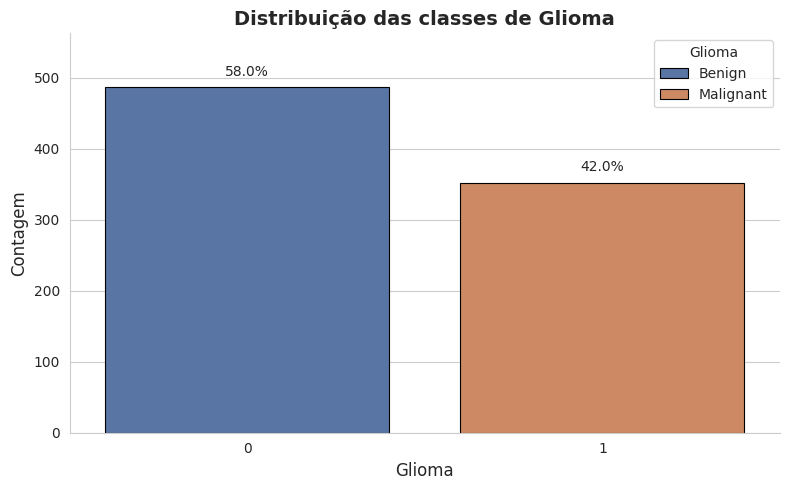

In [138]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

ax = sns.countplot(
    x='Glioma', data=df, hue='Glioma',
    palette=['#4c72b0', '#dd8452'],
    edgecolor='k', linewidth=0.8
)

# labels and title
ax.set_title('Distribuição das classes de Glioma', fontsize=14, fontweight='bold')
ax.set_xlabel('Glioma', fontsize=12)
ax.set_ylabel('Contagem', fontsize=12)

# ajustar limite y para espaço para anotações
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1] * 1.10)

# anotar contagens e percentuais em cada barra (ignora barras com altura 0)
total = len(df)
for p in ax.patches:
    height = p.get_height()
    if height <= 0:
        continue
    pct = 100 * height / total
    ax.annotate(f'{pct:.1f}%',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=10, fontweight='medium',
                xytext=(0,6), textcoords='offset points')

sns.despine(left=False, bottom=False)
plt.legend(title='Glioma', labels=['Benign', 'Malignant'])
plt.tight_layout()
plt.show()

## Correlação Entre Variáveis

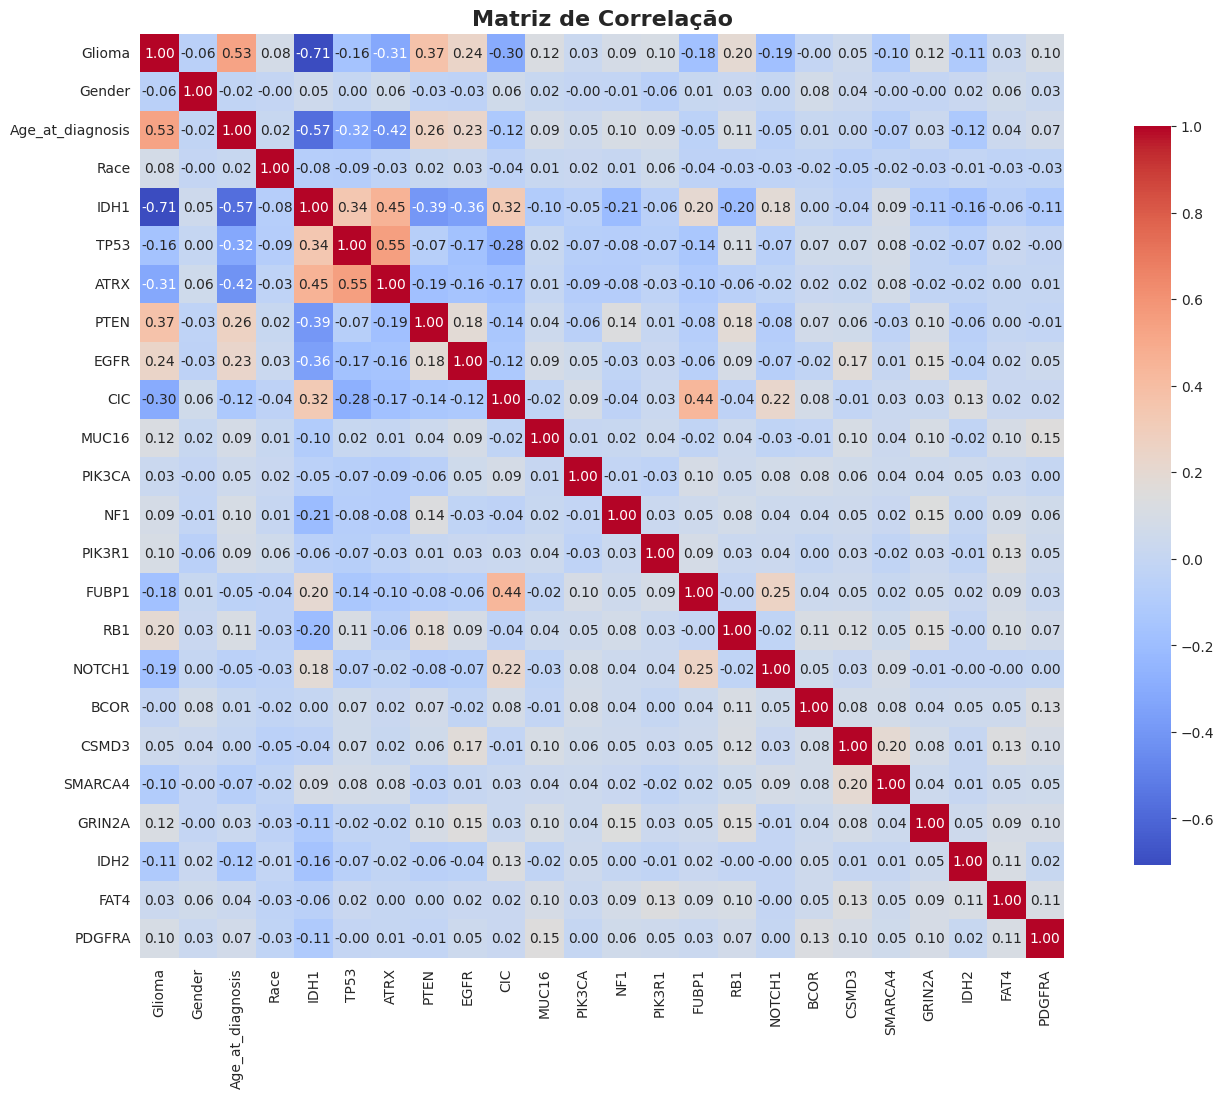

In [139]:
plt.figure(figsize=(18,12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação', fontsize=16, fontweight='bold')
plt.show()

### Melhores Correlações Com 'Glioma'

In [163]:
# Seleção de features usando apenas o conjunto de treino (sem olhar para val/test)
train_with_target = pd.concat([X_train, y_train], axis=1)
corr_train = train_with_target.corr()
correlation_with_target = corr_train['Glioma'].sort_values(ascending=False)
selected_features = correlation_with_target.index[1:4] 
correlation_with_target[1:4] 

Age_at_diagnosis    0.492413
PTEN                0.341701
EGFR                0.230461
Name: Glioma, dtype: float64

### Distribuição das Features por Classe

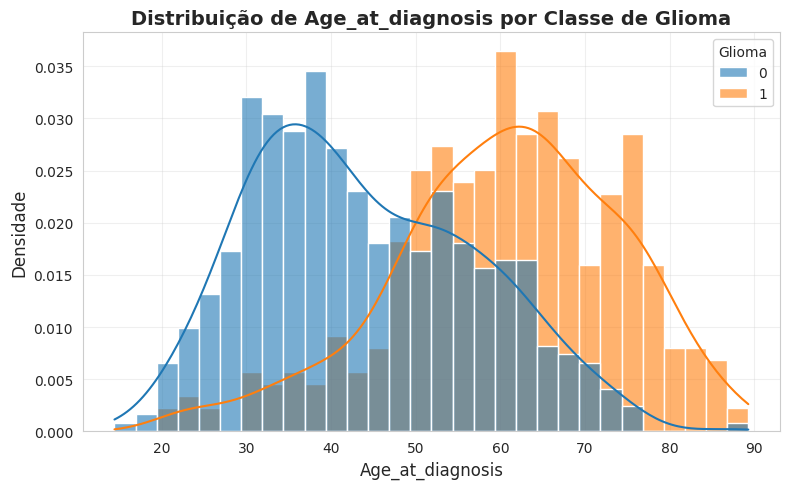

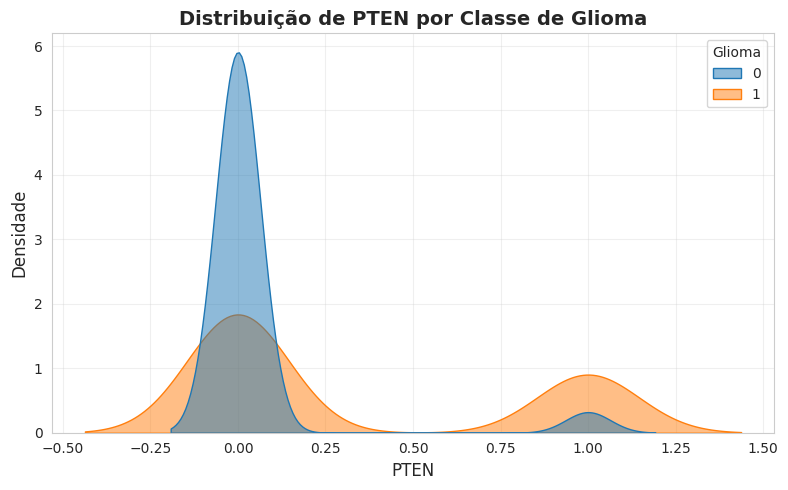

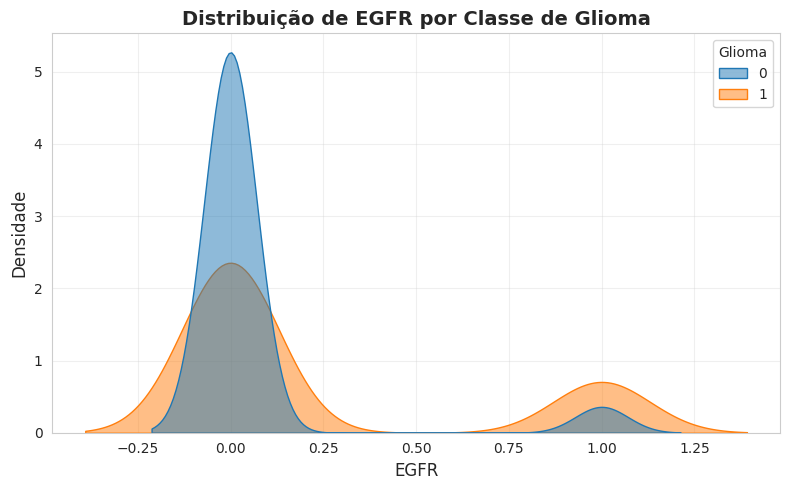

In [164]:
for feature in selected_features:
    plt.figure(figsize=(8, 5))

    if feature == 'Age_at_diagnosis':
        # Histograma + KDE (melhor visual para essa variável)
        sns.histplot(
            data=df, x=feature, hue="Glioma",
            kde=True, stat="density", common_norm=False, bins=30, alpha=0.6
        )
    else:
        # KDE padrão para features numéricas pequenas ou binárias
        sns.kdeplot(
            data=df, x=feature, hue='Glioma', fill=True,
            common_norm=False, 
            alpha=0.5
        )

    plt.title(f'Distribuição de {feature} por Classe de Glioma', fontsize=14, fontweight='bold')
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Densidade', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Contagem de Casos por Grupo de Variáveis


--- Feature: Age_at_diagnosis ---
Contagem por grupo (% do dataset):
Age_at_diagnosis_binned
(14.345, 29.394]     7.99
(29.394, 44.368]    29.20
(44.368, 59.342]    29.68
(59.342, 74.316]    25.39
(74.316, 89.29]      7.75
Glioma                   Benign  Malignant
Age_at_diagnosis_binned                   
(14.345, 29.394]           89.6       10.4
(29.394, 44.368]           87.3       12.7
(44.368, 59.342]           55.0       45.0
(59.342, 74.316]           33.8       66.2
(74.316, 89.29]             6.2       93.8


/tmp/ipykernel_19469/4159062621.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_temp.groupby([group_field, 'Glioma']).size().unstack(fill_value=0)


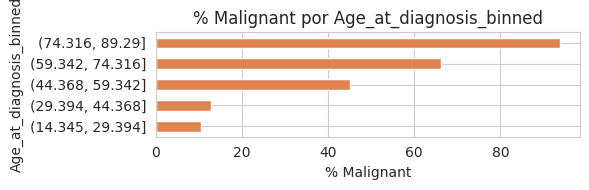


--- Feature: PTEN ---
Contagem por grupo (% do dataset):
PTEN
PTEN_not_mutated (0)    83.19
PTEN_mutated (1)        16.81
Glioma                Benign  Malignant
PTEN                                   
PTEN_not_mutated (0)    66.2       33.8
PTEN_mutated (1)        17.7       82.3


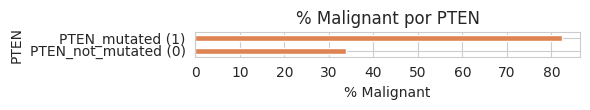


--- Feature: EGFR ---
Contagem por grupo (% do dataset):
EGFR
EGFR_not_mutated (0)    86.65
EGFR_mutated (1)        13.35
Glioma                Benign  Malignant
EGFR                                   
EGFR_not_mutated (0)    62.7       37.3
EGFR_mutated (1)        27.7       72.3


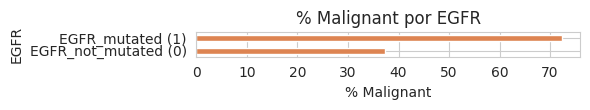


--- Feature: RB1 ---
Contagem por grupo (% do dataset):
RB1
RB1_not_mutated (0)    95.23
RB1_mutated (1)         4.77
Glioma               Benign  Malignant
RB1                                   
RB1_not_mutated (0)    60.2       39.8
RB1_mutated (1)        15.0       85.0


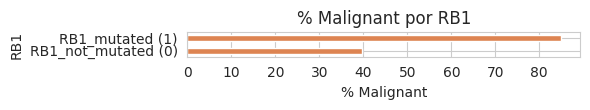

In [142]:
for feature in selected_features:
    print(f"\n--- Feature: {feature} ---")
    
    # agrupa Age_at_diagnosis em bins; outras features agrupam por valor
    if feature == 'Age_at_diagnosis':
        df_temp = df.copy()
        df_temp[f'{feature}_binned'] = pd.cut(df_temp[feature], bins=5)
        group_field = f'{feature}_binned'
        counts = df_temp.groupby([group_field, 'Glioma']).size().unstack(fill_value=0)
    else:
        group_field = feature
        counts = df.groupby([group_field, 'Glioma']).size().unstack(fill_value=0)

    # mostra percentuais do dataset por grupo (em vez de contagens absolutas)
    group_counts = counts.sum(axis=1)
    total = len(df)
    group_pct = (group_counts / total) * 100

    if feature in df.columns:
        unique_vals = np.unique(df[feature])
        if set(unique_vals).issubset({0, 1}):
            group_pct.index = group_pct.index.map({0: f'{feature}_not_mutated (0)', 1: f'{feature}_mutated (1)'})

    print("Contagem por grupo (% do dataset):")
    print(f"{group_pct.round(2).to_string()}")
    
    pct = counts.div(counts.sum(axis=1), axis=0) * 100

    # renomeia colunas se label_map existir
    if 'label_map' in globals():
        pct = pct.rename(columns=label_map)
    else:
        pct = pct.rename(columns={0: 'Benign', 1: 'Malignant'})

    # renomeia índice para melhor leitura se for 0/1 (para manter consistência com as contagens mostradas)
    if feature in df.columns:
        unique_vals = np.unique(df[feature])
        if set(unique_vals).issubset({0, 1}):
            pct.index = pct.index.map({0: f'{feature}_not_mutated (0)', 1: f'{feature}_mutated (1)'})

    compact = pct.round(1)
    print(compact.to_string())

    # garantir coluna de Malignant para o gráfico
    mal_col = 'Malignant' if 'Malignant' in compact.columns else compact.columns[-1]

    # gráfico simples do % Malignant (ordenado)
    ax = compact[mal_col].sort_values().plot(
        kind='barh', color='#dd8452', figsize=(6, max(1.2, 0.4 * len(compact)))
    )
    ax.set_xlabel('% Malignant')
    ax.set_title(f'% Malignant por {group_field}')
    plt.tight_layout()
    plt.show()

# Modelagem KNN 

## Divisão Treino/Teste

### Separação (X) e (y)

In [143]:
X = df.drop('Glioma', axis=1)
y = df['Glioma']

### Split dos Dados em Treino e Teste

In [144]:
# Split inicial (train/val/test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Garantir cópias para evitar SettingWithCopyWarning
X_train = X_train.copy()
X_val = X_val.copy()
X_test = X_test.copy()

## Seleção de Features

In [ ]:
features = [f for f in df.columns if f != 'Glioma' and f in X_train.columns]
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

## Normalização

In [146]:
# Normalizar 'Age_at_diagnosis' ajustando o scaler no treino e aplicando em val/test
scaler = MinMaxScaler()
cols_to_normalize = ['Age_at_diagnosis']

X_train[cols_to_normalize] = scaler.fit_transform(X_train[cols_to_normalize])
X_val[cols_to_normalize] = scaler.transform(X_val[cols_to_normalize])
X_test[cols_to_normalize] = scaler.transform(X_test[cols_to_normalize])

## Shape

In [147]:
print("Shapes")
print(f"Train -> {X_train.shape}")
print(f"Val   -> {X_val.shape}")
print(f"Test  -> {X_test.shape}")

Shapes
Train -> (503, 23)
Val   -> (168, 23)
Test  -> (168, 23)


## Treinamento do Modelo

In [148]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_val = knn.predict(X_val)
y_pred_test = knn.predict(X_test)

# Avaliação do Modelo

## KNN Padrão

### Matriz de Confusão

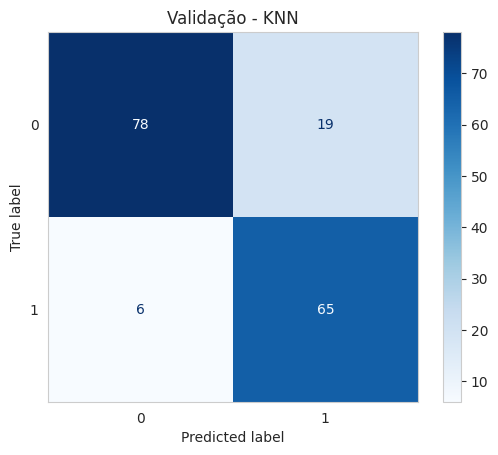

In [149]:
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Validação - KNN')
plt.grid(False)
plt.show()

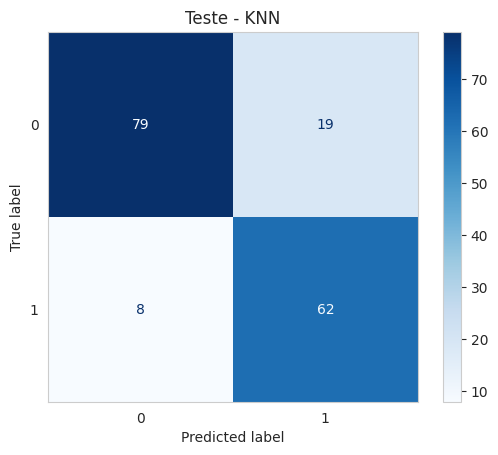

In [150]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Teste - KNN')
plt.grid(False)
plt.show()

### Métricas: Acuracia, Precision, Recall e f1-score

Pegando as métricas dos conjuntos de validação e teste.

In [151]:
accuracy_val, precision_val, recall_val, f1_val = (
    accuracy_score(y_val, y_pred_val),
    precision_score(y_val, y_pred_val),
    recall_score(y_val, y_pred_val),
    f1_score(y_val, y_pred_val),
)
accuracy, precision, recall, f1 = (
    accuracy_score(y_test, y_pred_test),
    precision_score(y_test, y_pred_test),
    recall_score(y_test, y_pred_test),
    f1_score(y_test, y_pred_test),
)

Resumo das métricas em formato de tabela

In [159]:
metrics = {
    'Validação': [accuracy_val, precision_val, recall_val, f1_val],
    'Teste':     [accuracy, precision, recall, f1]
}
index = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
df_metrics = pd.DataFrame(metrics, index=index)

print(
    df_metrics.to_string(
        formatters={
            'Validação': lambda x: f'{x:.4f} ({x*100:6.2f}%)',
            'Teste':     lambda x: f'{x:.4f} ({x*100:6.2f}%)'
        }
    )
)

                Validação            Teste
Acurácia 0.8512 ( 85.12%) 0.8393 ( 83.93%)
Precisão 0.7738 ( 77.38%) 0.7654 ( 76.54%)
Recall   0.9155 ( 91.55%) 0.8857 ( 88.57%)
F1-Score 0.8387 ( 83.87%) 0.8212 ( 82.12%)


Relatório de classificação — Teste


In [160]:
print(classification_report(y_test, y_pred_test, target_names=['Benign', 'Malignant'], digits=4))

              precision    recall  f1-score   support

      Benign     0.9080    0.8061    0.8541        98
   Malignant     0.7654    0.8857    0.8212        70

    accuracy                         0.8393       168
   macro avg     0.8367    0.8459    0.8376       168
weighted avg     0.8486    0.8393    0.8404       168



Relatório de classificação — Validação


In [161]:
print(classification_report(y_val, y_pred_val, target_names=['Benign', 'Malignant'], digits=4))

              precision    recall  f1-score   support

      Benign     0.9286    0.8041    0.8619        97
   Malignant     0.7738    0.9155    0.8387        71

    accuracy                         0.8512       168
   macro avg     0.8512    0.8598    0.8503       168
weighted avg     0.8632    0.8512    0.8521       168



### Curva ROC e AUC

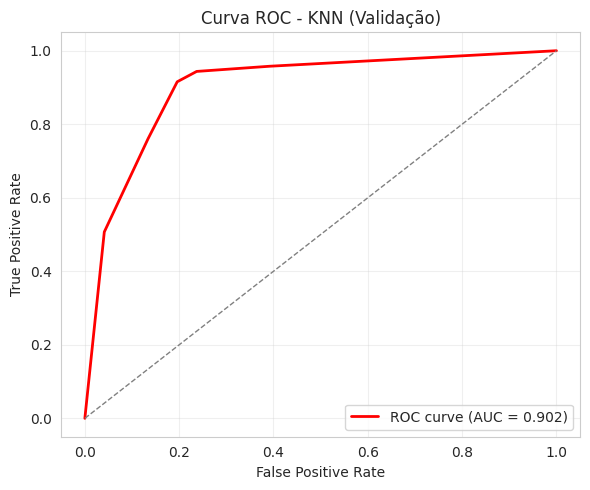

In [154]:
y_prob = knn.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - KNN (Validação)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


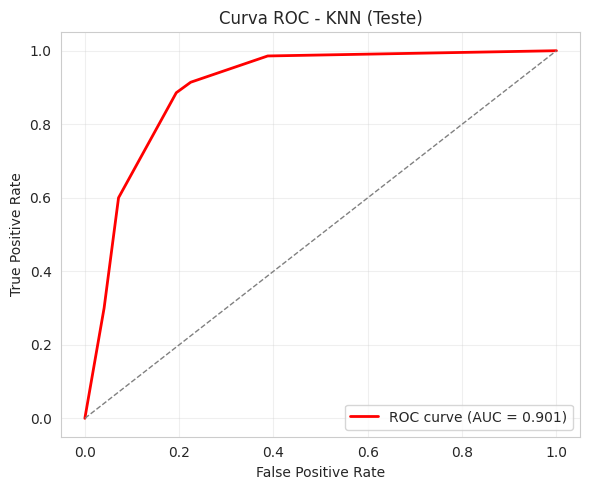

In [155]:
y_prob = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - KNN (Teste)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()